# Project 1

## Import Libraries

In [1]:
# import libraries
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from autofeat import AutoFeatRegressor

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV, SelectKBest, r_regression, f_regression
from sklearn.gaussian_process.kernels import Matern, RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, IsolationForest, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, make_scorer
from sklearn.decomposition import PCA

# outlier
from sklearn.base import OutlierMixin
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

import xgboost as xgb
import catboost as cat
import lightgbm as lgb

import torch
from torch import nn
from torch.nn import Module, Linear, Dropout
from torch.nn.functional import tanh, softmax, mse_loss, relu, sigmoid
from torch.optim import Adam, SGD

## Load Data

In [2]:
# load and split data (run)
data_X_train = pd.read_csv('Data/X_train.csv', header=0, index_col=0)
data_y_train = pd.read_csv('Data/y_train.csv', header=0, index_col=0)
data_X_test = pd.read_csv('Data/X_test.csv', header=0, index_col=0)

In [3]:
# data info (run)
data_X_train.describe()
"""
Data Shape: 1212 x 832
Data Lost: a lot
data scale: large
"""

'\nData Shape: 1212 x 832\nData Lost: a lot\ndata scale: large\n'

In [4]:
# transfer data to numpy (run)
X_train = data_X_train.to_numpy()
y_train = data_y_train.to_numpy()
X_test = data_X_test.to_numpy()

## Data Preprocessing

### 处理缺省值

In [5]:
# KNN Imputer (run)
imputer = KNNImputer(n_neighbors=5)
# imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

### 归一化

In [6]:
# scalar (run)
x_scalar = StandardScaler()
X_train = x_scalar.fit_transform(X_train)
X_test = x_scalar.transform(X_test)

# y_scalar = StandardScaler()
# y_train = y_scalar.fit_transform(y_train)

### 特征选择

#### 删除变化过小的列

In [7]:
# scalar (run)
del_columns_id_all0 = np.where(X_train.sum(axis=0) == 0)
X_train = np.delete(X_train, del_columns_id_all0, axis=1)
X_test = np.delete(X_test, del_columns_id_all0, axis=1)

#### 皮尔森系数

In [8]:
# pearson (run)
cc = r_regression(X_train, y_train.ravel())
del_columns_id_pearson = np.where(np.absolute(cc) <= 1e-2) # 删除pearson系数小于0.01的特征
X_train = np.delete(X_train, del_columns_id_pearson, axis=1)
X_test = np.delete(X_test, del_columns_id_pearson, axis=1)

#### 1. 删减特征

In [ ]:
# RFECV
estimator = LinearRegression()
selector = RFECV(estimator, step=1, cv=5, scoring='r2')
selector.fit(X_train, y_train)
feature_ranks = selector.ranking_

In [ ]:
# store the feature ranking
# pd.DataFrame(selector.ranking_).to_csv("Temp/feature_ranking.csv", header=False, index=False)
feature_ranks = pd.read_csv("Temp/feature_ranking.csv", header=None, index_col=None).to_numpy().reshape(-1)

In [ ]:
# choose features (top 95%)
def select_features(x, rank, threshold=0.8):
    drop_feature_ids = np.where(rank > int(threshold * max(rank)))
    selected_x = np.delete(x, drop_feature_ids, axis=1)
    return selected_x

X_train = select_features(X_train, feature_ranks, 0.95)
X_test = select_features(X_test, feature_ranks, 0.95)

#### 保留特征

In [9]:
# 使用selectkbest方法选择特征 (run)
skb = SelectKBest(f_regression, k=200)
X_train = skb.fit_transform(X_train, y_train.ravel())
X_test = skb.transform(X_test)
print(X_train.shape)

(1212, 200)


In [ ]:
# 使用autofeat方法选择特征
fes = AutoFeatRegressor(
    verbose=1
)
X_train = fes.fit_transform(X_train, y_train.ravel()).values

#### PCA

In [ ]:
pca = PCA(n_components=50)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

### 噪声探测

In [9]:
"""
！！！该方法具有较高的不确定性，不能保证有效 (run)
思路：
    1. 以每一个实际y为单位，找出上下年龄差为5的数据
    2. 计算该数据到这一组数据的均值的距离
    3. 如果距离大于某一阈值，则删除该数据

    Isolation Forest
"""
ERROR_COEFFICIENT = 2

deleted_sample_ids = []
errors = []
for row_i in range(X_train.shape[0]):
    X_row = X_train[row_i]
    y_row = y_train[row_i]

    sub_y_X = X_train[((y_train >= y_row - 5) & (y_train <= y_row + 5)).ravel()]
    if sub_y_X.shape[0] > 10:
    # if sub_y_X.shape[0] > 10 and (y_row[0] < 80 and y_row[0] > 50):
        sub_y_X_mean = np.average(sub_y_X, axis=0)
        sub_y_X_std = np.std(sub_y_X, axis=0)
        sub_y_X_error = (X_row > sub_y_X_mean + ERROR_COEFFICIENT * sub_y_X_std) | (X_row < sub_y_X_mean - ERROR_COEFFICIENT * sub_y_X_std)
        errors.append(sub_y_X_error.sum())
        if sub_y_X_error.sum() > X_train.shape[1] * 0.15:
            deleted_sample_ids.append(row_i)
    else:
        continue
X_train = np.delete(X_train, deleted_sample_ids, axis=0)
y_train = np.delete(y_train, deleted_sample_ids, axis=0)
print(X_train.shape)
print(y_train.shape)

(1180, 651)
(1180, 1)


In [ ]:
# 另一种方法 用四分位数解决outlier的问题
IQR_threshold = 15
IQR_efficient = 2


X_train = pd.DataFrame(X_train)
q1 = X_train.quantile(0.25)
q3 = X_train.quantile(0.75)
IQR = q3 - q1
mask = ((X_train < (q1 - IQR_efficient * IQR)) | (X_train > (q3 + IQR_efficient * IQR)))

# outliers = X_train[mask]
# outliers
mask = mask.sum(axis=1) > IQR_threshold
outliers = X_train[mask]
X_train = X_train[~mask].to_numpy()
y_train = y_train[~mask]
print(X_train.shape)
print(y_train.shape)

(1169, 200)
(1169, 1)


### 重采样

In [ ]:
def oversample_regression(X, y, num_samples):
    new_X_rows = np.zeros((num_samples, X.shape[1]))
    new_y_rows = np.zeros((num_samples, 1))
    for i in range(num_samples):
        sample1, sample2 = np.random.choice(X.shape[0], 2, replace=False)
        new_X_rows[i] = X[sample1] + np.random.random() * (X[sample2] - X[sample1])
        new_y_rows[i] = y[sample1] + np.random.random() * (y[sample2] - y[sample1])
    return new_X_rows, new_y_rows

oversample_ids = ((y_train <= 50) | (y_train >= 90)).ravel()
oversample_ids = np.where(oversample_ids == True)
to_oversample_X = X_train[oversample_ids]
to_oversample_y = y_train[oversample_ids]

oversample_X, oversample_y = oversample_regression(to_oversample_X, to_oversample_y, 200)
X_train = np.concatenate((X_train, oversample_X), axis=0)
y_train = np.concatenate((y_train, oversample_y), axis=0)
X_train.shape

(1336, 200)

In [ ]:
oversample_ids = ((y_train <= 50) | (y_train >= 90)).ravel()
oversample_ids = np.where(oversample_ids == True)
oversample_X = X_train[oversample_ids]
oversample_y = y_train[oversample_ids]
oversample_X = np.concatenate([oversample_X, ] * 2, axis=0)
oversample_y = np.concatenate([oversample_y, ] * 2, axis=0)
X_train = np.concatenate([X_train, oversample_X], axis=0)
y_train = np.concatenate([y_train, oversample_y], axis=0)
X_train.shape

(1230, 200)

## Model Selection

### Linear Regression

In [ ]:
# LR
fold_num = 5

kf = KFold(n_splits=fold_num)
fold_score = 0
for i, (train_ids, valid_ids) in enumerate(kf.split(X_train)):
    # split validation data
    fold_X_train = X_train[train_ids]
    fold_y_train = y_train[train_ids]
    fold_X_valid = X_train[valid_ids]
    fold_y_valid = y_train[valid_ids]

    # train model
    model = LinearRegression()
    model.fit(fold_X_train, fold_y_train)
    fold_y_pred = model.predict(fold_X_valid)

    # calculate score
    fold_score += r2_score(fold_y_valid, fold_y_pred)
fold_score /= fold_num
print(fold_score)

-2.890191269931073


### Kernel Ridge Regression

In [ ]:
# Ridge Regression
fold_num = 5

kf = KFold(n_splits=fold_num)
fold_score = 0
for i, (train_ids, valid_ids) in enumerate(kf.split(X_train)):
    # split validation data
    fold_X_train = X_train[train_ids]
    fold_y_train = y_train[train_ids]
    fold_X_valid = X_train[valid_ids]
    fold_y_valid = y_train[valid_ids]

    # train model
    model = KernelRidge(kernel="rbf")
    model.fit(fold_X_train, fold_y_train)
    fold_y_pred = model.predict(fold_X_valid)

    # calculate score
    fold_score += r2_score(fold_y_valid, fold_y_pred)
fold_score /= fold_num
print(fold_score)

0.019787009919412422


### Gaussian Process Regressor

In [40]:
# Gaussian Process Regressor (Matern)
fold_num = 5

kf = KFold(n_splits=fold_num)
fold_scores = []
for i, (train_ids, valid_ids) in enumerate(kf.split(X_train)):
    # split validation data
    fold_X_train = X_train[train_ids]
    fold_y_train = y_train[train_ids]
    fold_X_valid = X_train[valid_ids]
    fold_y_valid = y_train[valid_ids]

    # train model
    # kernel = RBF(length_scale=1)
    param = {'alpha': 1e-09, 'kernel': Matern(length_scale=1, nu=1.5) + RBF(length_scale=1)}
    model = GaussianProcessRegressor(**param)
    model.fit(fold_X_train, fold_y_train)
    fold_y_pred = model.predict(fold_X_valid)

    # calculate score
    fold_scores.append(r2_score(fold_y_valid, fold_y_pred))
fold_score = np.average(fold_scores)
print(fold_score)

0.6707424896372844


In [23]:
# Grid Search CV
model = GaussianProcessRegressor(random_state=0)
params = {
    "kernel": [Matern(nu=1.5), Matern(nu=0.5), Matern(nu=2.5), RBF(), Matern(nu=1.5) + Matern(nu=0.5), Matern(nu=1.5) + RBF(), Matern(nu=0.5) + RBF()], 
    "alpha": [1e-11, 2e-11, 5e-11, 1e-10, 2e-10, 5e-10, 1e-9, 2e-9, 5e-9, 1e-8, 2e-8, 5e-8], 
}
scorer = make_scorer(r2_score, greater_is_better=Tru8e)
regressor = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring=scorer)
regressor.fit(X_train, y_train)
regressor.cv_results_["rank_test_score"]

c:\Users\Hongyi LAN\miniconda3\envs\aml_project\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


array([52, 25, 72, 81, 41,  6, 13, 51, 26, 71, 84, 42,  3, 15, 60, 27, 70,
       83, 43,  2, 14, 59, 28, 69, 82, 44,  8, 16, 58, 29, 68, 73, 45,  7,
       17, 57, 30, 67, 80, 37,  4, 18, 56, 31, 66, 79, 38,  1, 19, 55, 32,
       65, 78, 39,  5, 20, 54, 33, 64, 77, 40, 10, 21, 53, 34, 63, 76, 46,
       11, 22, 50, 35, 62, 75, 47, 12, 23, 49, 36, 61, 74, 48,  9, 24])

In [39]:
max_score_index = list(regressor.cv_results_["rank_test_score"]).index(1)
regressor.cv_results_["params"][max_score_index]

{'alpha': 1e-09,
 'kernel': Matern(length_scale=1, nu=1.5) + RBF(length_scale=1)}

In [44]:
regressor.cv_results_["mean_test_score"].sort()
regressor.cv_results_["mean_test_score"]

array([0.36589649, 0.36589649, 0.36589649, 0.36589649, 0.36589649,
       0.36589649, 0.3658965 , 0.3658965 , 0.36589651, 0.36589653,
       0.3658966 , 0.36589722, 0.59100063, 0.59100063, 0.59100063,
       0.59100063, 0.59100063, 0.59100063, 0.59100063, 0.59100063,
       0.59100063, 0.59100063, 0.59100063, 0.59100064, 0.62322728,
       0.62322728, 0.62322728, 0.62322728, 0.62322728, 0.62322728,
       0.62322729, 0.62322729, 0.62322729, 0.62322729, 0.62322729,
       0.62322729, 0.63649129, 0.63649129, 0.63649129, 0.63649129,
       0.63649129, 0.63649129, 0.63649129, 0.63649129, 0.63649129,
       0.63649129, 0.63649129, 0.63649129, 0.6499944 , 0.6499944 ,
       0.6499944 , 0.6499944 , 0.6499944 , 0.6499944 , 0.6499944 ,
       0.6499944 , 0.6499944 , 0.6499944 , 0.6499944 , 0.6499944 ,
       0.66667487, 0.66667487, 0.66667487, 0.66667487, 0.66667487,
       0.66667487, 0.66667487, 0.66667487, 0.66667487, 0.66667487,
       0.66667487, 0.66667487, 0.67074245, 0.67074245, 0.67074

In [ ]:
# 用GP检查outlier的最佳
outlier_detectors = [EllipticEnvelope(), LocalOutlierFactor(n_neighbors=5), LocalOutlierFactor(n_neighbors=10), LocalOutlierFactor(n_neighbors=20), OneClassSVM(kernel="linear"), OneClassSVM(kernel="poly"), OneClassSVM(kernel="rbf"), OneClassSVM(kernel="sigmoid")]
results = []
for outlier_detector in outlier_detectors:
    outlier_ids = outlier_detector.fit_predict(X_train, y_train)
    non_outlier_ids = np.where(outlier_ids != -1)
    X_train_new = X_train[non_outlier_ids]
    y_train_new = y_train[non_outlier_ids]
    kf = KFold(n_splits=5)
    fold_scores = []
    for i, (train_ids, valid_ids) in enumerate(kf.split(X_train_new)):
        # split validation data
        fold_X_train = X_train_new[train_ids]
        fold_y_train = y_train_new[train_ids]
        fold_X_valid = X_train_new[valid_ids]
        fold_y_valid = y_train_new[valid_ids]

        # train model
        # kernel = RBF(length_scale=1)
        param = {'alpha': 1e-09, 'kernel': Matern(length_scale=1, nu=1.5) + RBF(length_scale=1)}
        model = GaussianProcessRegressor(**param)
        model.fit(fold_X_train, fold_y_train)
        fold_y_pred = model.predict(fold_X_valid)

        # calculate score
        fold_scores.append(r2_score(fold_y_valid, fold_y_pred))
    fold_score = np.average(fold_scores)
    results.append(fold_score)
results

c:\Users\Hongyi LAN\miniconda3\envs\aml_project\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [11]:
# 用GP检查Feature Detection
feature_detector_selection_results = []
for k in range(20, 501, 20):
    feature_detector = SelectKBest(f_regression, k=k)
    X_train_new = feature_detector.fit_transform(X_train, y_train.ravel())
    kf = KFold(n_splits=5)
    fold_scores = []
    for i, (train_ids, valid_ids) in enumerate(kf.split(X_train_new)):
        # split validation data
        fold_X_train = X_train_new[train_ids]
        fold_y_train = y_train[train_ids]
        fold_X_valid = X_train_new[valid_ids]
        fold_y_valid = y_train[valid_ids]

        # train model
        # kernel = RBF(length_scale=1)
        param = {'alpha': 1e-09, 'kernel': Matern(length_scale=1, nu=1.5) + RBF(length_scale=1)}
        model = GaussianProcessRegressor(**param)
        model.fit(fold_X_train, fold_y_train)
        fold_y_pred = model.predict(fold_X_valid)

        # calculate score
        fold_scores.append(r2_score(fold_y_valid, fold_y_pred))
    fold_score = np.average(fold_scores)
    feature_detector_selection_results.append(fold_score)

c:\Users\Hongyi LAN\miniconda3\envs\aml_project\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Hongyi LAN\miniconda3\envs\aml_project\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [ ]:
# Gaussian Process Regressor (RBF)
fold_num = 5

kf = KFold(n_splits=fold_num)
fold_scores = []
for i, (train_ids, valid_ids) in enumerate(kf.split(X_train)):
    # split validation data
    fold_X_train = X_train[train_ids]
    fold_y_train = y_train[train_ids]
    fold_X_valid = X_train[valid_ids]
    fold_y_valid = y_train[valid_ids]

    # train model
    model = GaussianProcessRegressor(kernel=RBF(length_scale=10), random_state=0)
    model.fit(fold_X_train, fold_y_train)
    fold_y_pred = model.predict(fold_X_valid)

    # calculate score
    fold_scores.append(r2_score(fold_y_valid, fold_y_pred))
fold_score = np.average(fold_scores)
print(fold_score)

-0.01484695627455086


### SVR

In [ ]:
# SVR
fold_num = 5

kf = KFold(n_splits=fold_num)
fold_scores = []
for i, (train_ids, valid_ids) in enumerate(kf.split(X_train)):
    # split validation data
    fold_X_train = X_train[train_ids]
    fold_y_train = y_train[train_ids]
    fold_X_valid = X_train[valid_ids]
    fold_y_valid = y_train[valid_ids]

    # train model
    model = SVR(kernel="rbf")
    model.fit(fold_X_train, fold_y_train.ravel())
    fold_y_pred = model.predict(fold_X_valid)

    # calculate score
    fold_scores.append(r2_score(fold_y_valid, fold_y_pred))
fold_score = np.average(fold_scores)
print(fold_score)

0.27278034373557075


### Random Forest

In [ ]:
# Random Forest Regressor
fold_num = 5

kf = KFold(n_splits=fold_num)
fold_scores = []
for i, (train_ids, valid_ids) in enumerate(kf.split(X_train)):
    # split validation data
    fold_X_train = X_train[train_ids]
    fold_y_train = y_train[train_ids]
    fold_X_valid = X_train[valid_ids]
    fold_y_valid = y_train[valid_ids]

    # train model
    model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=0, criterion="squared_error")
    model.fit(fold_X_train, fold_y_train.ravel())
    fold_y_pred = model.predict(fold_X_valid)

    # calculate score
    fold_scores.append(r2_score(fold_y_valid, fold_y_pred))
fold_score = np.average(fold_scores)
print(fold_score)

0.45761414755344837


In [11]:
# Extra Trees
fold_num = 5

kf = KFold(n_splits=fold_num)
fold_scores = []
for i, (train_ids, valid_ids) in enumerate(kf.split(X_train)):
    # split validation data
    fold_X_train = X_train[train_ids]
    fold_y_train = y_train[train_ids]
    fold_X_valid = X_train[valid_ids]
    fold_y_valid = y_train[valid_ids]

    # train model
    model = ExtraTreesRegressor(n_jobs=1, max_depth=None, n_estimators=180, random_state=0, min_samples_split=3, max_features=None)
    model.fit(fold_X_train, fold_y_train.ravel())
    fold_y_pred = model.predict(fold_X_valid)

    # calculate score
    fold_scores.append(r2_score(fold_y_valid, fold_y_pred))
fold_score = np.average(fold_scores)
print(fold_score)

0.6372541119242721


In [ ]:
# Isolation Forest Regressor
fold_num = 5

kf = KFold(n_splits=fold_num)
fold_scores = []
for i, (train_ids, valid_ids) in enumerate(kf.split(X_train)):
    # split validation data
    fold_X_train = X_train[train_ids]
    fold_y_train = y_train[train_ids]
    fold_X_valid = X_train[valid_ids]
    fold_y_valid = y_train[valid_ids]

    # train model
    model = IsolationForest(n_estimators=100, max_features=0.6, random_state=0)
    model.fit(fold_X_train, fold_y_train)
    fold_y_pred = model.predict(fold_X_valid)

    # calculate score
    fold_scores.append(r2_score(fold_y_valid, fold_y_pred))
fold_score = np.average(fold_scores)
print(fold_score)

-50.88352200279015


In [ ]:
# Gradient Boosting Regressor
fold_num = 5

kf = KFold(n_splits=fold_num)
fold_scores = []
for i, (train_ids, valid_ids) in enumerate(kf.split(X_train)):
    # split validation data
    fold_X_train = X_train[train_ids]
    fold_y_train = y_train[train_ids]
    fold_X_valid = X_train[valid_ids]
    fold_y_valid = y_train[valid_ids]

    # train model
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
    model.fit(fold_X_train, fold_y_train.ravel())
    fold_y_pred = np.round(model.predict(fold_X_valid))

    # calculate score
    fold_scores.append(r2_score(fold_y_valid, fold_y_pred))
fold_score = np.average(fold_scores)
print(fold_score)

0.6455286476185035


In [ ]:
# Adaboost Regressor
fold_num = 5

kf = KFold(n_splits=fold_num)
fold_scores = []
for i, (train_ids, valid_ids) in enumerate(kf.split(X_train)):
    # split validation data
    fold_X_train = X_train[train_ids]
    fold_y_train = y_train[train_ids]
    fold_X_valid = X_train[valid_ids]
    fold_y_valid = y_train[valid_ids]

    # train model
    model = AdaBoostRegressor(n_estimators=100, learning_rate=0.1, loss="square")
    model.fit(fold_X_train, fold_y_train.ravel())
    fold_y_pred = model.predict(fold_X_valid)

    # calculate score
    fold_scores.append(r2_score(fold_y_valid, fold_y_pred))
fold_score = np.average(fold_scores)
print(fold_score)

0.4110280800135076


### XGBoost

In [ ]:
# XGBoost
fold_num = 5

kf = KFold(n_splits=fold_num)
fold_scores = []
for i, (train_ids, valid_ids) in enumerate(kf.split(X_train)):
    # split validation data
    fold_X_train = X_train[train_ids]
    fold_y_train = y_train[train_ids]
    fold_X_valid = X_train[valid_ids]
    fold_y_valid = y_train[valid_ids]

    # train model
    model = xgb.XGBRegressor(n_estimators=150, max_depth=5, learning_rate=0.11, n_jobs=20)
    model.fit(fold_X_train, fold_y_train.ravel())
    fold_y_pred = np.round(model.predict(fold_X_valid))

    # calculate score
    fold_scores.append(r2_score(fold_y_valid, fold_y_pred))
fold_score = np.average(fold_scores)
print(fold_score)

0.6628370028029413


### CatBoost

In [ ]:
# CatBoost (run)
# 模型：换loss function
fold_num = 5

kf = KFold(n_splits=fold_num)
fold_scores = []
for i, (train_ids, valid_ids) in enumerate(kf.split(X_train)):
    # split validation data
    fold_X_train = X_train[train_ids]
    fold_y_train = y_train[train_ids]
    fold_X_valid = X_train[valid_ids]
    fold_y_valid = y_train[valid_ids]

    # train model
    model = cat.CatBoostRegressor(max_depth=5, iterations=1000, task_type="GPU")
    model.fit(fold_X_train, fold_y_train.ravel())
    fold_y_pred = model.predict(fold_X_valid)

    # calculate score
    fold_scores.append(r2_score(fold_y_valid, fold_y_pred))
fold_score = np.average(fold_scores)
print(fold_score)

Learning rate set to 0.040295
0:	learn: 9.4190472	total: 133ms	remaining: 2m 13s
1:	learn: 9.2840904	total: 137ms	remaining: 1m 8s
2:	learn: 9.1558665	total: 141ms	remaining: 47s
3:	learn: 9.0200143	total: 146ms	remaining: 36.4s
4:	learn: 8.8958874	total: 150ms	remaining: 29.8s
5:	learn: 8.7738262	total: 154ms	remaining: 25.6s
6:	learn: 8.6562437	total: 159ms	remaining: 22.6s
7:	learn: 8.5421858	total: 163ms	remaining: 20.2s
8:	learn: 8.4248963	total: 166ms	remaining: 18.3s
9:	learn: 8.3147908	total: 170ms	remaining: 16.8s
10:	learn: 8.2055781	total: 174ms	remaining: 15.6s
11:	learn: 8.1070973	total: 177ms	remaining: 14.6s
12:	learn: 8.0045417	total: 180ms	remaining: 13.7s
13:	learn: 7.9120680	total: 183ms	remaining: 12.9s
14:	learn: 7.8152770	total: 186ms	remaining: 12.2s
15:	learn: 7.7286704	total: 189ms	remaining: 11.6s
16:	learn: 7.6466897	total: 192ms	remaining: 11.1s
17:	learn: 7.5691358	total: 195ms	remaining: 10.6s
18:	learn: 7.4890870	total: 198ms	remaining: 10.2s
19:	learn: 7

In [ ]:
# Grid Search CV
model = cat.CatBoostRegressor()
params = {
    "kernel": [Matern(nu=1.5), Matern(nu=0.5), Matern(nu=2.5), RBF(), Matern(nu=1.5) + Matern(nu=0.5), Matern(nu=1.5) + RBF(), Matern(nu=0.5) + RBF()], 
    "alpha": [1e-11, 2e-11, 5e-11, 1e-10, 2e-10, 5e-10, 1e-9, 2e-9, 5e-9, 1e-8, 2e-8, 5e-8], 
}
scorer = make_scorer(r2_score, greater_is_better=True)
regressor = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring=scorer)
regressor.fit(X_train, y_train)
regressor.cv_results_["rank_test_score"]

### LGBM

In [ ]:
# CatBoost
fold_num = 5

kf = KFold(n_splits=fold_num)
fold_scores = []
for i, (train_ids, valid_ids) in enumerate(kf.split(X_train)):
    # split validation data
    fold_X_train = X_train[train_ids]
    fold_y_train = y_train[train_ids]
    fold_X_valid = X_train[valid_ids]
    fold_y_valid = y_train[valid_ids]

    # train model
    model = lgb.LGBMRegressor(n_estimators=50)
    model.fit(fold_X_train, fold_y_train.ravel())
    fold_y_pred = model.predict(fold_X_valid)

    # calculate score
    fold_scores.append(r2_score(fold_y_valid, fold_y_pred))
fold_score = np.average(fold_scores)
print(fold_score)

0.5184643170957269


### 组合模型（xgb cat lgbm）

In [10]:
# ensemble model xgb+cat+lgb
class EnsembleModel(object):
    def __init__(self):
        # self.xgb = xgb.XGBRegressor(n_estimators=150, max_depth=5, learning_rate=0.11, n_jobs=20)
        self.cat = cat.CatBoostRegressor(iterations=1000)
        self.lgb = lgb.LGBMRegressor(n_estimators=150)
    
    def fit(self, X, y):
        # self.xgb.fit(X, y)
        self.cat.fit(X, y)
        self.lgb.fit(X, y)
    
    def predict(self, X):
        # return np.mean([self.xgb.predict(X), self.cat.predict(X), self.lgb.predict(X)], axis=0)
        return np.mean([self.cat.predict(X), self.lgb.predict(X)], axis=0)

In [ ]:
# Ensemble Model
fold_num = 5

kf = KFold(n_splits=fold_num)
fold_scores = []
for i, (train_ids, valid_ids) in enumerate(kf.split(X_train)):
    # split validation data
    fold_X_train = X_train[train_ids]
    fold_y_train = y_train[train_ids]
    fold_X_valid = X_train[valid_ids]
    fold_y_valid = y_train[valid_ids]

    # train model
    model = EnsembleModel()
    model.fit(fold_X_train, fold_y_train.ravel())
    fold_y_pred = np.round(model.predict(fold_X_valid))

    # calculate score
    fold_scores.append(r2_score(fold_y_valid, fold_y_pred))
fold_score = np.average(fold_scores)
print(fold_score)

Learning rate set to 0.04074
0:	learn: 9.6739327	total: 153ms	remaining: 2m 32s
1:	learn: 9.5399741	total: 159ms	remaining: 1m 19s
2:	learn: 9.4212297	total: 165ms	remaining: 54.8s
3:	learn: 9.2949211	total: 170ms	remaining: 42.3s
4:	learn: 9.1780530	total: 175ms	remaining: 34.9s
5:	learn: 9.0704191	total: 181ms	remaining: 30s
6:	learn: 8.9594317	total: 187ms	remaining: 26.5s
7:	learn: 8.8524807	total: 193ms	remaining: 23.9s
8:	learn: 8.7582062	total: 198ms	remaining: 21.8s
9:	learn: 8.6684705	total: 203ms	remaining: 20.1s
10:	learn: 8.5818256	total: 209ms	remaining: 18.8s
11:	learn: 8.5009233	total: 214ms	remaining: 17.6s
12:	learn: 8.4179029	total: 220ms	remaining: 16.7s
13:	learn: 8.3349018	total: 225ms	remaining: 15.9s
14:	learn: 8.2548302	total: 230ms	remaining: 15.1s
15:	learn: 8.1811100	total: 236ms	remaining: 14.5s
16:	learn: 8.1086641	total: 242ms	remaining: 14s
17:	learn: 8.0298359	total: 247ms	remaining: 13.5s
18:	learn: 7.9582470	total: 252ms	remaining: 13s
19:	learn: 7.885

In [ ]:
original_model = EnsembleModel()
original_model.fit(fold_X_train, fold_y_train.ravel())
y_pred = original_model.predict(fold_X_valid)

y_low_ids = np.where(fold_y_train.ravel() <= 55)
y_high_ids = np.where(fold_y_train.ravel() >= 85)
X_low = fold_X_train[y_low_ids]
y_low = fold_y_train[y_low_ids]
X_high = fold_X_train[y_high_ids]
y_high = fold_y_train[y_high_ids]

valid_y_low_ids = np.where(fold_y_valid.ravel() <= 55)
valid_y_high_ids = np.where(fold_y_valid.ravel() >= 85)
valid_X_low = fold_X_valid[valid_y_low_ids]
valid_y_low = fold_y_valid[valid_y_low_ids]
valid_X_high = fold_X_valid[valid_y_high_ids]
valid_y_high = fold_y_valid[valid_y_high_ids]

low_model = EnsembleModel()
high_model = EnsembleModel()
low_model.fit(X_low, y_low.ravel())
high_model.fit(X_high, y_high.ravel())

low_predict = low_model.predict(valid_X_low)
high_predict = high_model.predict(valid_X_high)

Learning rate set to 0.04033
0:	learn: 9.3024960	total: 6.99ms	remaining: 6.99s
1:	learn: 9.1326847	total: 11.9ms	remaining: 5.95s
2:	learn: 8.9933554	total: 16.8ms	remaining: 5.57s
3:	learn: 8.8505612	total: 21.9ms	remaining: 5.44s
4:	learn: 8.7055577	total: 26.8ms	remaining: 5.33s
5:	learn: 8.5701338	total: 31.4ms	remaining: 5.2s
6:	learn: 8.4381620	total: 36.5ms	remaining: 5.17s
7:	learn: 8.3071033	total: 41.1ms	remaining: 5.1s
8:	learn: 8.1727816	total: 45.6ms	remaining: 5.02s
9:	learn: 8.0616183	total: 50.8ms	remaining: 5.02s
10:	learn: 7.9470787	total: 55.8ms	remaining: 5.02s
11:	learn: 7.8585707	total: 60.7ms	remaining: 5s
12:	learn: 7.7551307	total: 65.6ms	remaining: 4.98s
13:	learn: 7.6513454	total: 70.7ms	remaining: 4.98s
14:	learn: 7.5497792	total: 75.7ms	remaining: 4.97s
15:	learn: 7.4602916	total: 80.7ms	remaining: 4.96s
16:	learn: 7.3807445	total: 85.9ms	remaining: 4.97s
17:	learn: 7.3116891	total: 90.9ms	remaining: 4.96s
18:	learn: 7.2356891	total: 95.8ms	remaining: 4.95

### 组合模型（增强）

In [ ]:
# ensemble model xgb+cat+lgb
class EnsembleModelReinforcement(object):
    def __init__(self):
        self.low_threshold = 50
        self.high_threshold = 80

        self.normal_model = EnsembleModel()

        self.low_model = EnsembleModel()
        self.least_model = EnsembleModel()

        self.high_model = EnsembleModel()
        self.highest_model = EnsembleModel()
    
    def fit(self, X, y):
        # 分离数据
        y_low_ids = np.where(y <= 55)
        y_high_ids = np.where(y >= 80)
        y_least_ids = np.where(y <= 50)
        y_highest_ids = np.where(y >= 90)
        self.normal_model.fit(X, y)
        self.low_model.fit(X[y_low_ids], y[y_low_ids])
        self.least_model.fit(X[y_least_ids], y[y_least_ids])
        self.high_model.fit(X[y_high_ids], y[y_high_ids])
        self.highest_model.fit(X[y_highest_ids], y[y_highest_ids])
        return
    
    def predict(self, X):
        normal_result = self.normal_model.predict(X)
        normal_ids_matrix = ((normal_result >= 60) & (normal_result <= 75))
        low_ids = np.where(normal_result <= 60)
        high_ids = np.where(normal_result >= 75)

        low_result = self.low_model.predict(X)
        high_result = self.high_model.predict(X)
        least_ids = np.where(low_result <= 50)
        highest_ids = np.where(high_result >= 85)

        least_result = self.least_model.predict(X)
        highest_result = self.highest_model.predict(X)

        all_result = normal_result * normal_ids_matrix + low_result * (self.inverse_matrix(self.id2matrix(least_ids, X.shape[0]))) * (self.id2matrix(low_ids, X.shape[0])) + high_result * (self.inverse_matrix(self.id2matrix(highest_ids, X.shape[0]))) *\
            (self.id2matrix(high_ids, X.shape[0])) + least_result * self.id2matrix(least_ids, X.shape[0]) + highest_result * self.id2matrix(highest_ids, X.shape[0])
        return all_result

    def id2matrix(self, ids: list, n: int):
        matrix = np.zeros(n)
        for id in ids:
            matrix[id] = 1
        return matrix
    
    def inverse_matrix(self, matrix: np.ndarray):
        return np.abs(matrix - 1)
    
# Ensemble Model (Reinforced)
fold_num = 5

kf = KFold(n_splits=fold_num)
fold_scores = []
for i, (train_ids, valid_ids) in enumerate(kf.split(X_train)):
    # split validation data
    fold_X_train = X_train[train_ids]
    fold_y_train = y_train[train_ids]
    fold_X_valid = X_train[valid_ids]
    fold_y_valid = y_train[valid_ids]

    # train model
    model = EnsembleModelReinforcement()
    model.fit(fold_X_train, fold_y_train.ravel())
    fold_y_pred = np.round(model.predict(fold_X_valid))

    # calculate score
    fold_scores.append(r2_score(fold_y_valid, fold_y_pred))
fold_score = np.average(fold_scores)
print(fold_score)

Learning rate set to 0.040323
0:	learn: 9.4037782	total: 6.2ms	remaining: 6.2s
1:	learn: 9.2312535	total: 11ms	remaining: 5.48s
2:	learn: 9.0819408	total: 15.9ms	remaining: 5.27s
3:	learn: 8.9293769	total: 20.6ms	remaining: 5.13s
4:	learn: 8.7946144	total: 25ms	remaining: 4.98s
5:	learn: 8.6622111	total: 30ms	remaining: 4.97s
6:	learn: 8.5377671	total: 34.4ms	remaining: 4.88s
7:	learn: 8.4072318	total: 38.7ms	remaining: 4.79s
8:	learn: 8.2842064	total: 43ms	remaining: 4.74s
9:	learn: 8.1613392	total: 47.7ms	remaining: 4.73s
10:	learn: 8.0296218	total: 52.5ms	remaining: 4.72s
11:	learn: 7.9317022	total: 56.6ms	remaining: 4.66s
12:	learn: 7.8302171	total: 61.1ms	remaining: 4.64s
13:	learn: 7.7352061	total: 65.8ms	remaining: 4.64s
14:	learn: 7.6401899	total: 70.5ms	remaining: 4.63s
15:	learn: 7.5544692	total: 75ms	remaining: 4.61s
16:	learn: 7.4746271	total: 79.9ms	remaining: 4.62s
17:	learn: 7.3941212	total: 84.3ms	remaining: 4.6s
18:	learn: 7.3110917	total: 88.4ms	remaining: 4.57s
19:	l

### Neural Network

In [ ]:
class NNModel(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.nn1 = Linear(200, 256)
        # self.dropout1 = Dropout(0.5)
        self.nn2 = Linear(256, 64)
        # self.dropout2 = Dropout(0.5)
        self.nn3 = Linear(64, 1)
        
    def forward(self, x):
        output = sigmoid(self.nn1(x))
        # output = self.dropout1(output)
        output = sigmoid(self.nn2(output))
        # output = self.dropout2(output)
        output = self.nn3(output)
        return output

In [ ]:
# Neural Network
fold_num = 5

kf = KFold(n_splits=fold_num)
fold_scores = []
for i, (train_ids, valid_ids) in enumerate(kf.split(X_train)):
    # split validation data
    fold_X_train = torch.from_numpy(X_train[train_ids]).float()
    fold_y_train = torch.from_numpy(y_train[train_ids]).float()
    fold_X_valid = torch.from_numpy(X_train[valid_ids]).float()
    fold_y_valid = torch.from_numpy(y_train[valid_ids]).float()

    # train model
    model = NNModel()
    optimizer = SGD(model.parameters(), lr=0.015, momentum=0.9)
    epoch_num = 150
    for epoch in range(epoch_num):
        optimizer.zero_grad()
        output = model(fold_X_train)
        loss = mse_loss(output, fold_y_train)

        loss.backward()
        optimizer.step()
        valid_loss = mse_loss(model(fold_X_valid), fold_y_valid)
        print("The epoch is {}, the loss is {:.03f}, the loss in validation data is {:.03f}".format(epoch, loss, valid_loss))

    fold_y_pred = model(fold_X_valid).detach().numpy()

    # calculate score
    fold_scores.append(r2_score(fold_y_valid, fold_y_pred))
fold_score = np.average(fold_scores)
print(fold_score)

The epoch is 0, the loss is 5015.557, the loss in validation data is 1451.557
The epoch is 1, the loss is 1441.213, the loss in validation data is 4181.361
The epoch is 2, the loss is 4220.127, the loss in validation data is 1434.339
The epoch is 3, the loss is 1460.927, the loss in validation data is 1288.183
The epoch is 4, the loss is 1279.185, the loss in validation data is 2626.787
The epoch is 5, the loss is 2609.954, the loss in validation data is 121.457
The epoch is 6, the loss is 132.830, the loss in validation data is 2393.577
The epoch is 7, the loss is 2425.821, the loss in validation data is 394.511
The epoch is 8, the loss is 411.596, the loss in validation data is 1305.913
The epoch is 9, the loss is 1296.785, the loss in validation data is 1196.299
The epoch is 10, the loss is 1187.971, the loss in validation data is 301.476
The epoch is 11, the loss is 317.130, the loss in validation data is 1445.790
The epoch is 12, the loss is 1472.476, the loss in validation data i

In [ ]:
pd.DataFrame([(fold_y_valid.detach().numpy() * 100).ravel(), (fold_y_pred * 100).ravel()])

,0,1,2,3,4,5,6,7,8,9,...,217,218,219,220,221,222,223,224,225,226
0,88.00000,77.0000,66.000000,63.000000,70.000000,49.000000,77.000000,85.00000,63.000000,52.999996,...,77.000000,76.000000,80.000000,56.000000,69.000000,75.000000,86.00000,68.000000,71.000000,52.999996
1,70.98037,70.7006,74.506813,73.756241,68.706367,72.723038,75.560249,68.03923,71.611771,74.690208,...,76.683571,76.612625,72.068871,70.635918,65.719597,69.181099,69.32547,69.093559,72.001694,75.453476


## 预测

In [11]:
# model = cat.CatBoostRegressor(max_depth=5, iterations=1000)
param = {'alpha': 1e-09, 'kernel': Matern(length_scale=1, nu=1.5) + RBF(length_scale=1)}
model = GaussianProcessRegressor(**param)
model.fit(X_train, y_train.ravel())
y_pred = np.round(model.predict(X_test))
y_pred_df = pd.DataFrame(y_pred, columns=["y"], index=data_X_test.index).reset_index()
y_pred_df["id"] = y_pred_df["id"].astype(int)
y_pred_df

,id,y
0,0,61.0
1,1,75.0
2,2,71.0
3,3,77.0
4,4,73.0
...,...,...
771,771,68.0
772,772,73.0
773,773,76.0
774,774,71.0


In [12]:
y_pred_df.to_csv("result_1.csv", index=False)

## 数据分析

<BarContainer object of 13 artists>

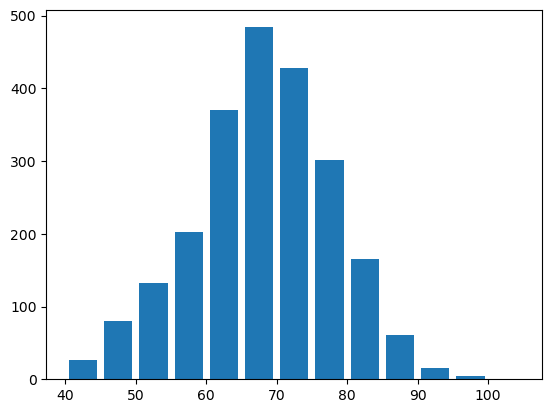

In [ ]:
# 查看y label的分布
y_sums = []
for start_age in range(40, 105, 5):
    sub_y_id = ((y_train >= start_age) & (y_train < start_age + 10)).ravel()
    y_sums.append(sub_y_id.sum())
plt.bar(np.arange(42.5, 107.5, 5), y_sums, width=4)

<BarContainer object of 6 artists>

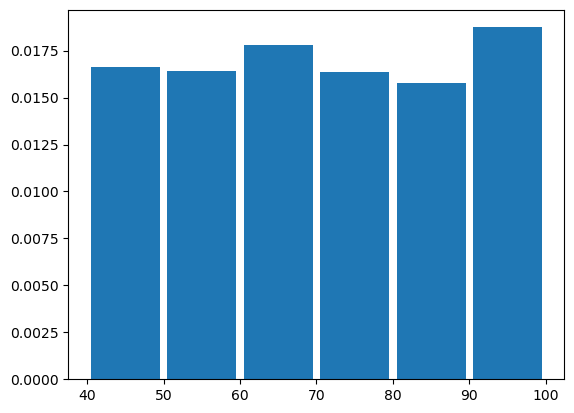

In [ ]:
# 分析哪些数据预测的有问题
"""
训练误差的分布是基本均匀的，但是在90-100这个区间的预测效果相对较差
"""
model = xgb.XGBRegressor(n_estimators=200, max_depth=7, learning_rate=0.1, n_jobs=20)
model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_train).ravel()
y_error = np.abs(y_pred - y_train.ravel()).ravel()

sub_errors = []
for start_age in range(40, 100, 10):
    sub_y_id = ((y_train >= start_age) & (y_train < start_age + 10)).ravel()
    sub_y_error = (y_error * sub_y_id).sum() / sub_y_id.sum()
    sub_errors.append(sub_y_error)
plt.bar(range(45, 100, 10), sub_errors, width=9)

Learning rate set to 0.040323
0:	learn: 9.4037782	total: 5.95ms	remaining: 5.94s
1:	learn: 9.2312535	total: 10.9ms	remaining: 5.46s
2:	learn: 9.0819408	total: 16.2ms	remaining: 5.37s
3:	learn: 8.9293769	total: 21.1ms	remaining: 5.25s
4:	learn: 8.7946144	total: 25.3ms	remaining: 5.03s
5:	learn: 8.6622111	total: 30.1ms	remaining: 4.99s
6:	learn: 8.5377671	total: 34.6ms	remaining: 4.91s
7:	learn: 8.4072318	total: 39ms	remaining: 4.84s
8:	learn: 8.2842064	total: 43.5ms	remaining: 4.79s
9:	learn: 8.1613392	total: 48.2ms	remaining: 4.78s
10:	learn: 8.0296218	total: 52.9ms	remaining: 4.75s
11:	learn: 7.9317022	total: 57.1ms	remaining: 4.7s
12:	learn: 7.8302171	total: 61.8ms	remaining: 4.69s
13:	learn: 7.7352061	total: 66.5ms	remaining: 4.68s
14:	learn: 7.6401899	total: 70.8ms	remaining: 4.65s
15:	learn: 7.5544692	total: 75.4ms	remaining: 4.64s
16:	learn: 7.4746271	total: 80.3ms	remaining: 4.64s
17:	learn: 7.3941212	total: 84.8ms	remaining: 4.63s
18:	learn: 7.3110917	total: 89.2ms	remaining: 4

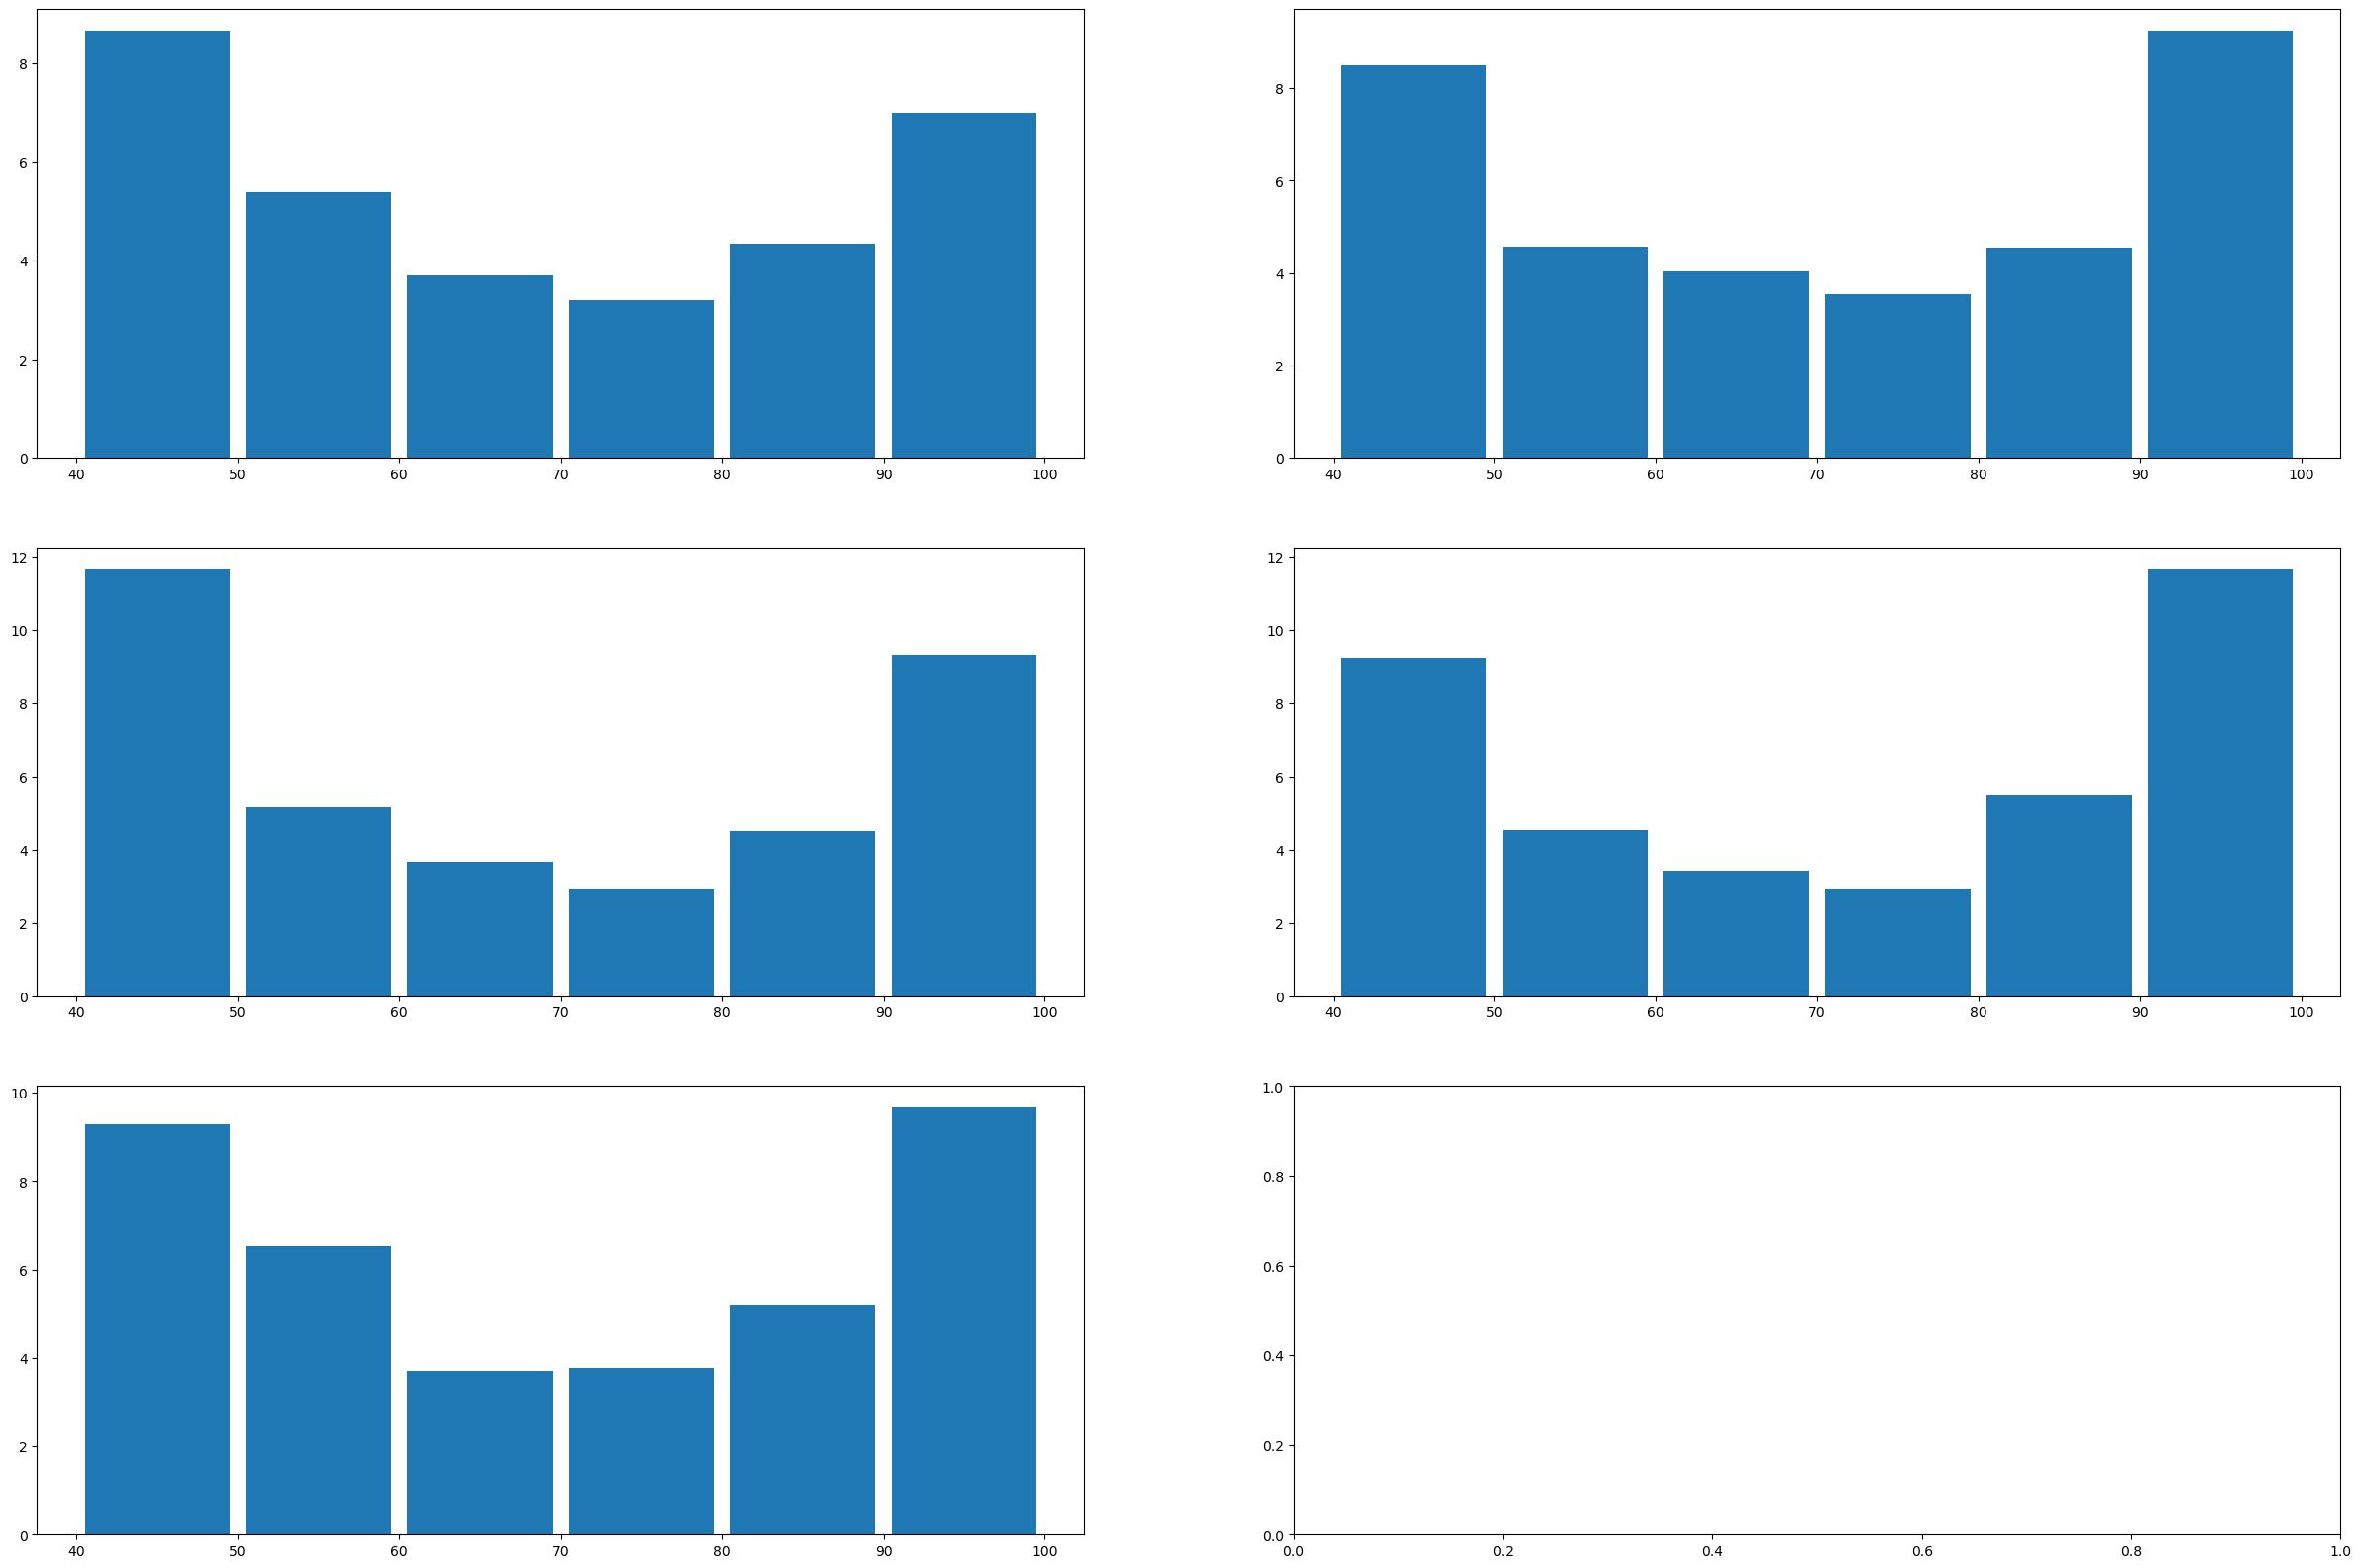

In [ ]:
# 测试泛化误差
"""
经过检查，泛化误差主要集中在40-50和90-100两个区间
"""
fold_num = 5

kf = KFold(n_splits=fold_num)
fold_scores = []
fold_y_preds = []
fold_y_valids = []
for i, (train_ids, valid_ids) in enumerate(kf.split(X_train)):
    # split validation data
    fold_X_train = X_train[train_ids]
    fold_y_train = y_train[train_ids]
    fold_X_valid = X_train[valid_ids]
    fold_y_valid = y_train[valid_ids]

    # train model
    model = EnsembleModel()
    model.fit(fold_X_train, fold_y_train.ravel())
    fold_y_pred = np.round(model.predict(fold_X_valid))
    fold_y_preds.append(fold_y_pred.ravel())
    fold_y_valids.append(fold_y_valid.ravel())

    # calculate score
    fold_scores.append(r2_score(fold_y_valid, fold_y_pred))
fold_score = np.average(fold_scores)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30, 20))
for i, (fold_y_pred, fold_y_valid) in enumerate(zip(fold_y_preds, fold_y_valids)):
    fold_y_error = np.abs(fold_y_pred - fold_y_valid)
    sub_errors = []
    for start_age in range(40, 100, 10):
        sub_y_id = ((fold_y_valid >= start_age) & (fold_y_valid < start_age + 10))
        sub_y_error = (fold_y_error * sub_y_id).sum() / sub_y_id.sum()
        sub_errors.append(sub_y_error)

    axes[i // 2][i % 2].bar(range(45, 100, 10), sub_errors, width=9)

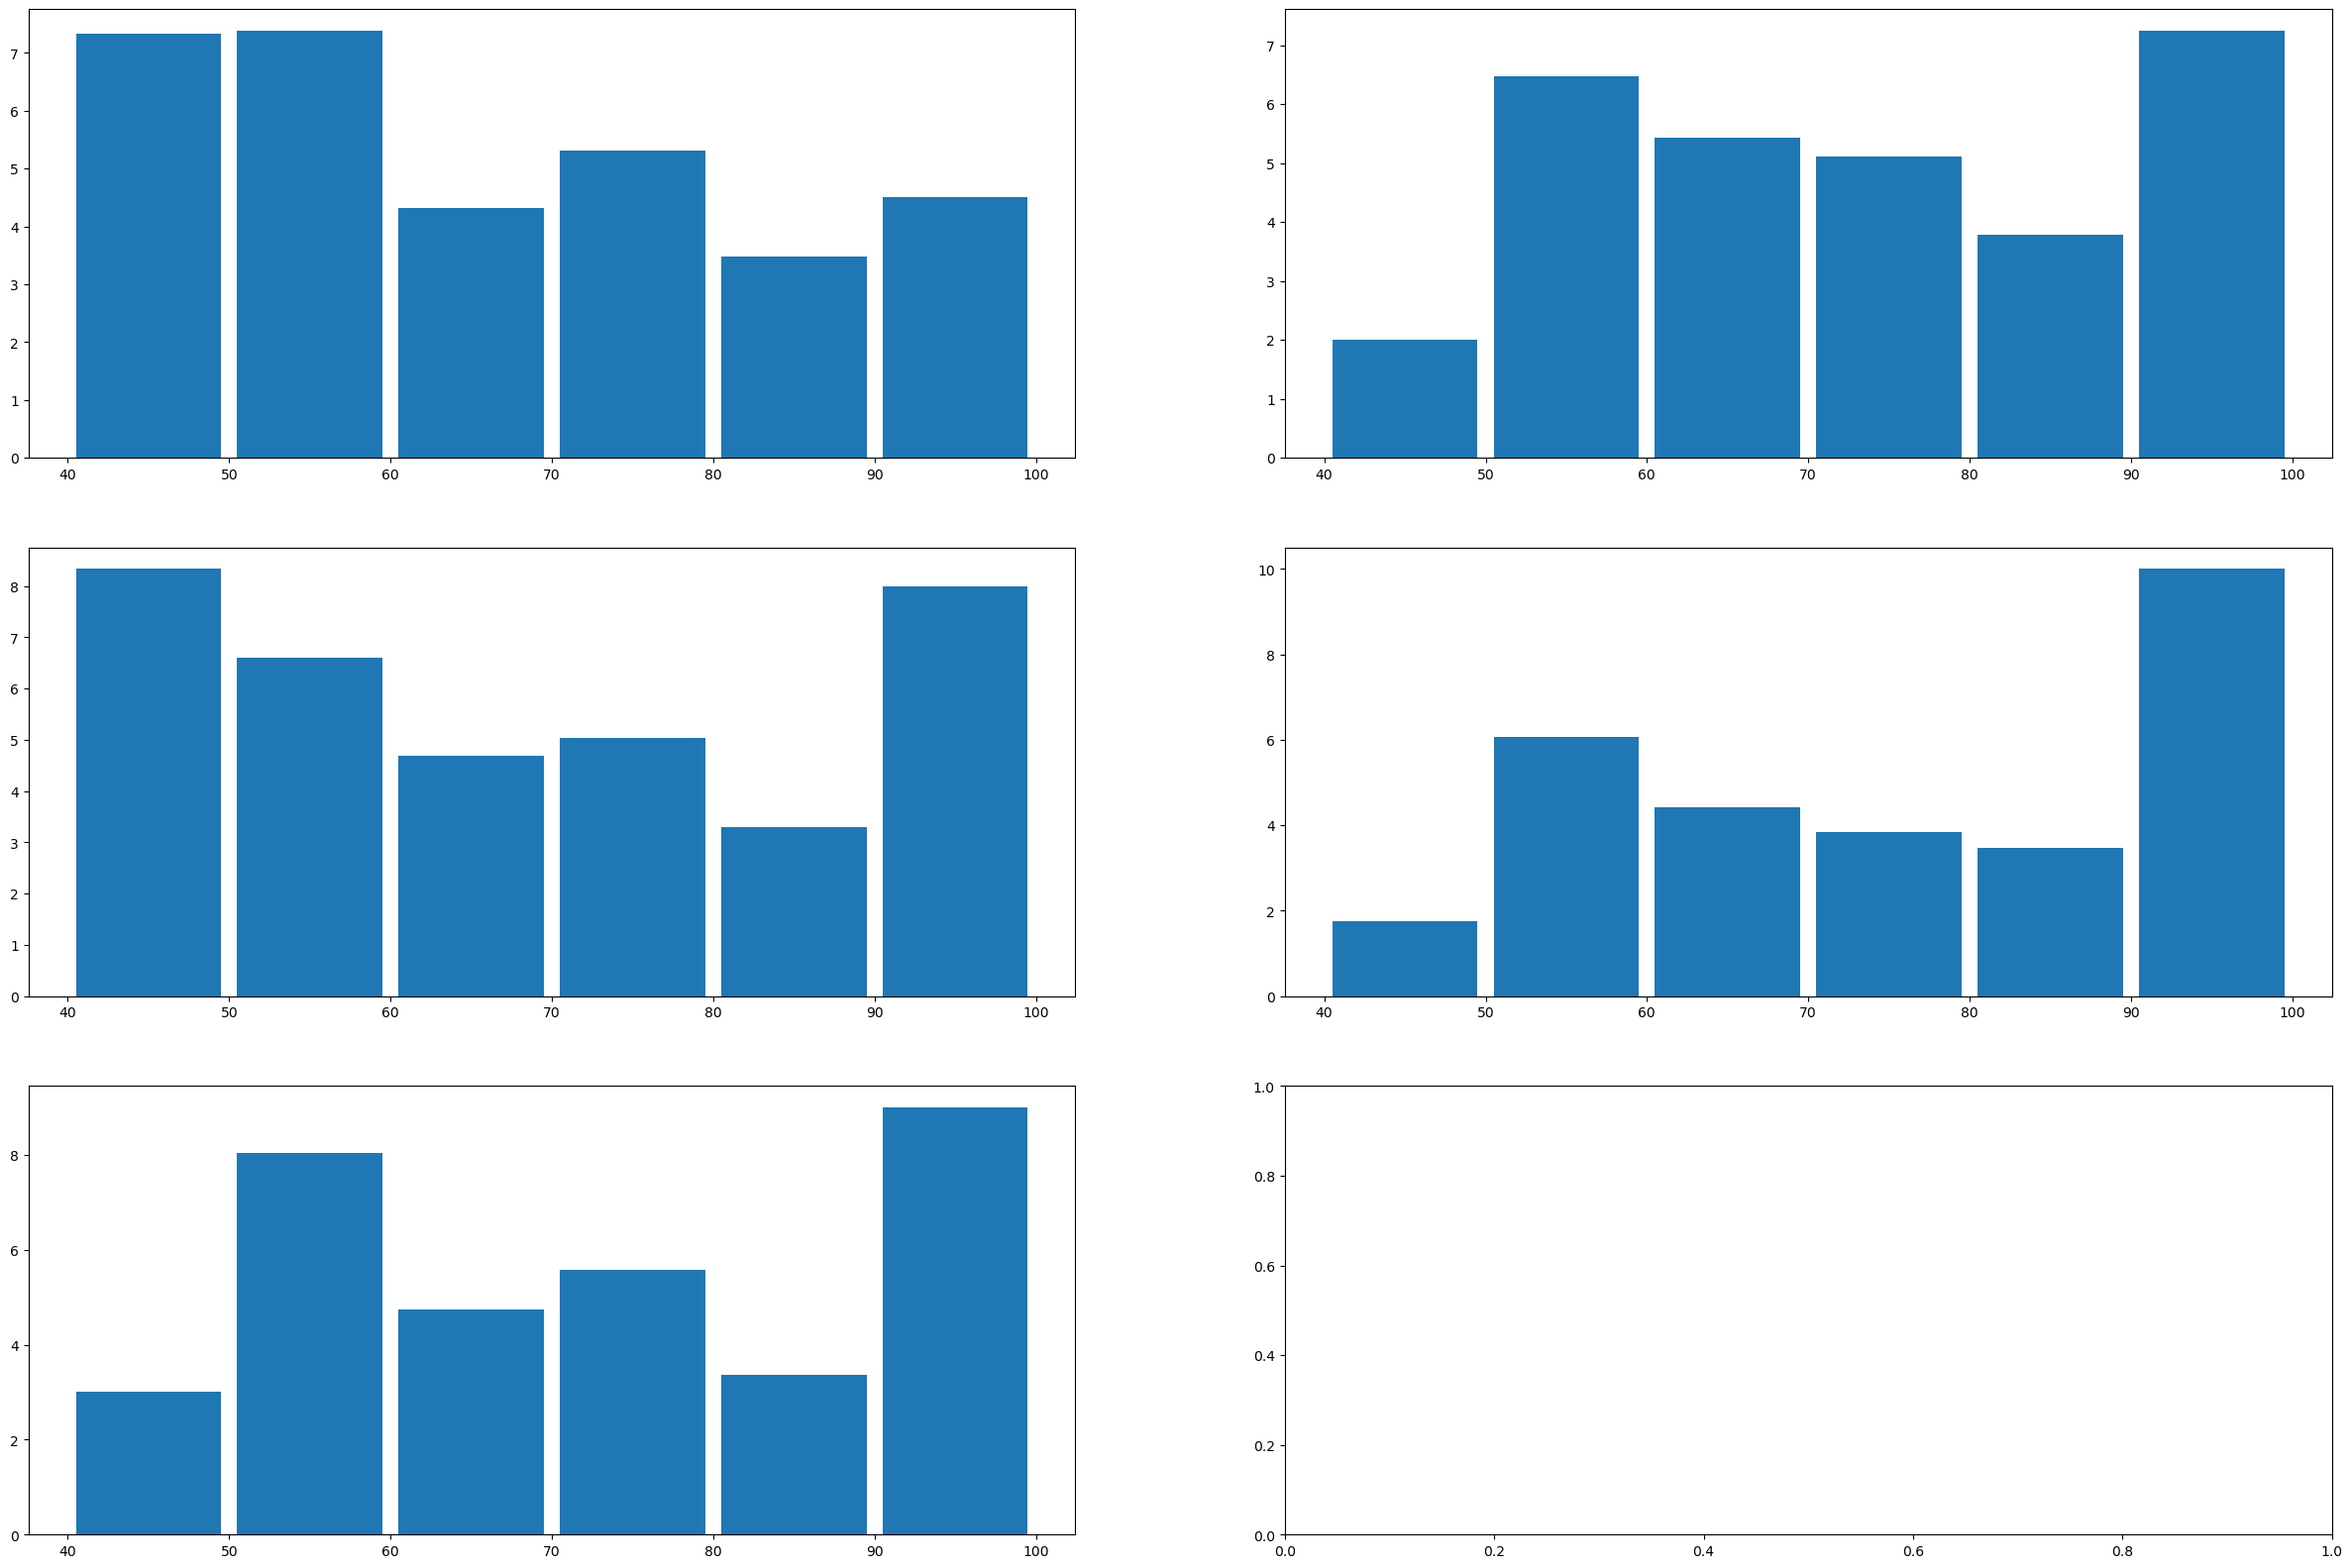

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30, 20))
for i, (fold_y_pred, fold_y_valid) in enumerate(zip(fold_y_preds, fold_y_valids)):
    fold_y_error = np.abs(fold_y_pred - fold_y_valid)
    sub_errors = []
    for start_age in range(40, 100, 10):
        sub_y_id = ((fold_y_valid >= start_age) & (fold_y_valid < start_age + 10))
        sub_y_error = (fold_y_error * sub_y_id).sum() / sub_y_id.sum()
        sub_errors.append(sub_y_error)

    axes[i // 2][i % 2].bar(range(45, 100, 10), sub_errors, width=9)

In [ ]:
fold_y_pred[np.where(sub_y_id == True)]

array([85., 85., 81.])

In [ ]:
fold_y_valid[np.where(sub_y_id == True)]

array([95., 91., 94.])

<BarContainer object of 6 artists>

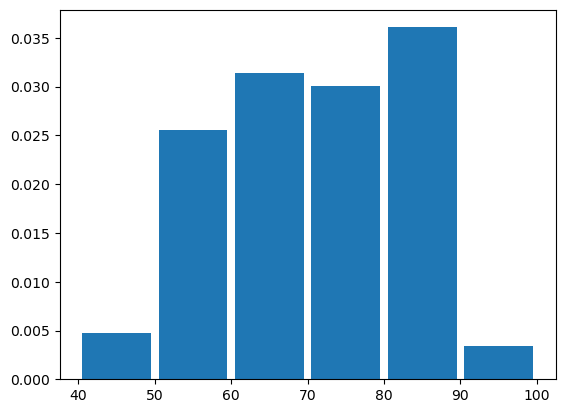

In [ ]:
# 分析哪些数据预测的有问题
"""
重采样后，训练误差的分布是基本均匀的，但是在90-100这个区间的预测效果相对较差
"""
model = xgb.XGBRegressor(n_estimators=200, max_depth=7, learning_rate=0.1, n_jobs=20)
model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_train).ravel()
y_error = np.abs(y_pred - y_train.ravel()).ravel()

sub_errors = []
for start_age in range(40, 100, 10):
    sub_y_id = ((y_train >= start_age) & (y_train < start_age + 10)).ravel()
    sub_y_error = (y_error * sub_y_id).sum() / sub_y_id.sum()
    sub_errors.append(sub_y_error)
plt.bar(range(45, 100, 10), sub_errors, width=9)

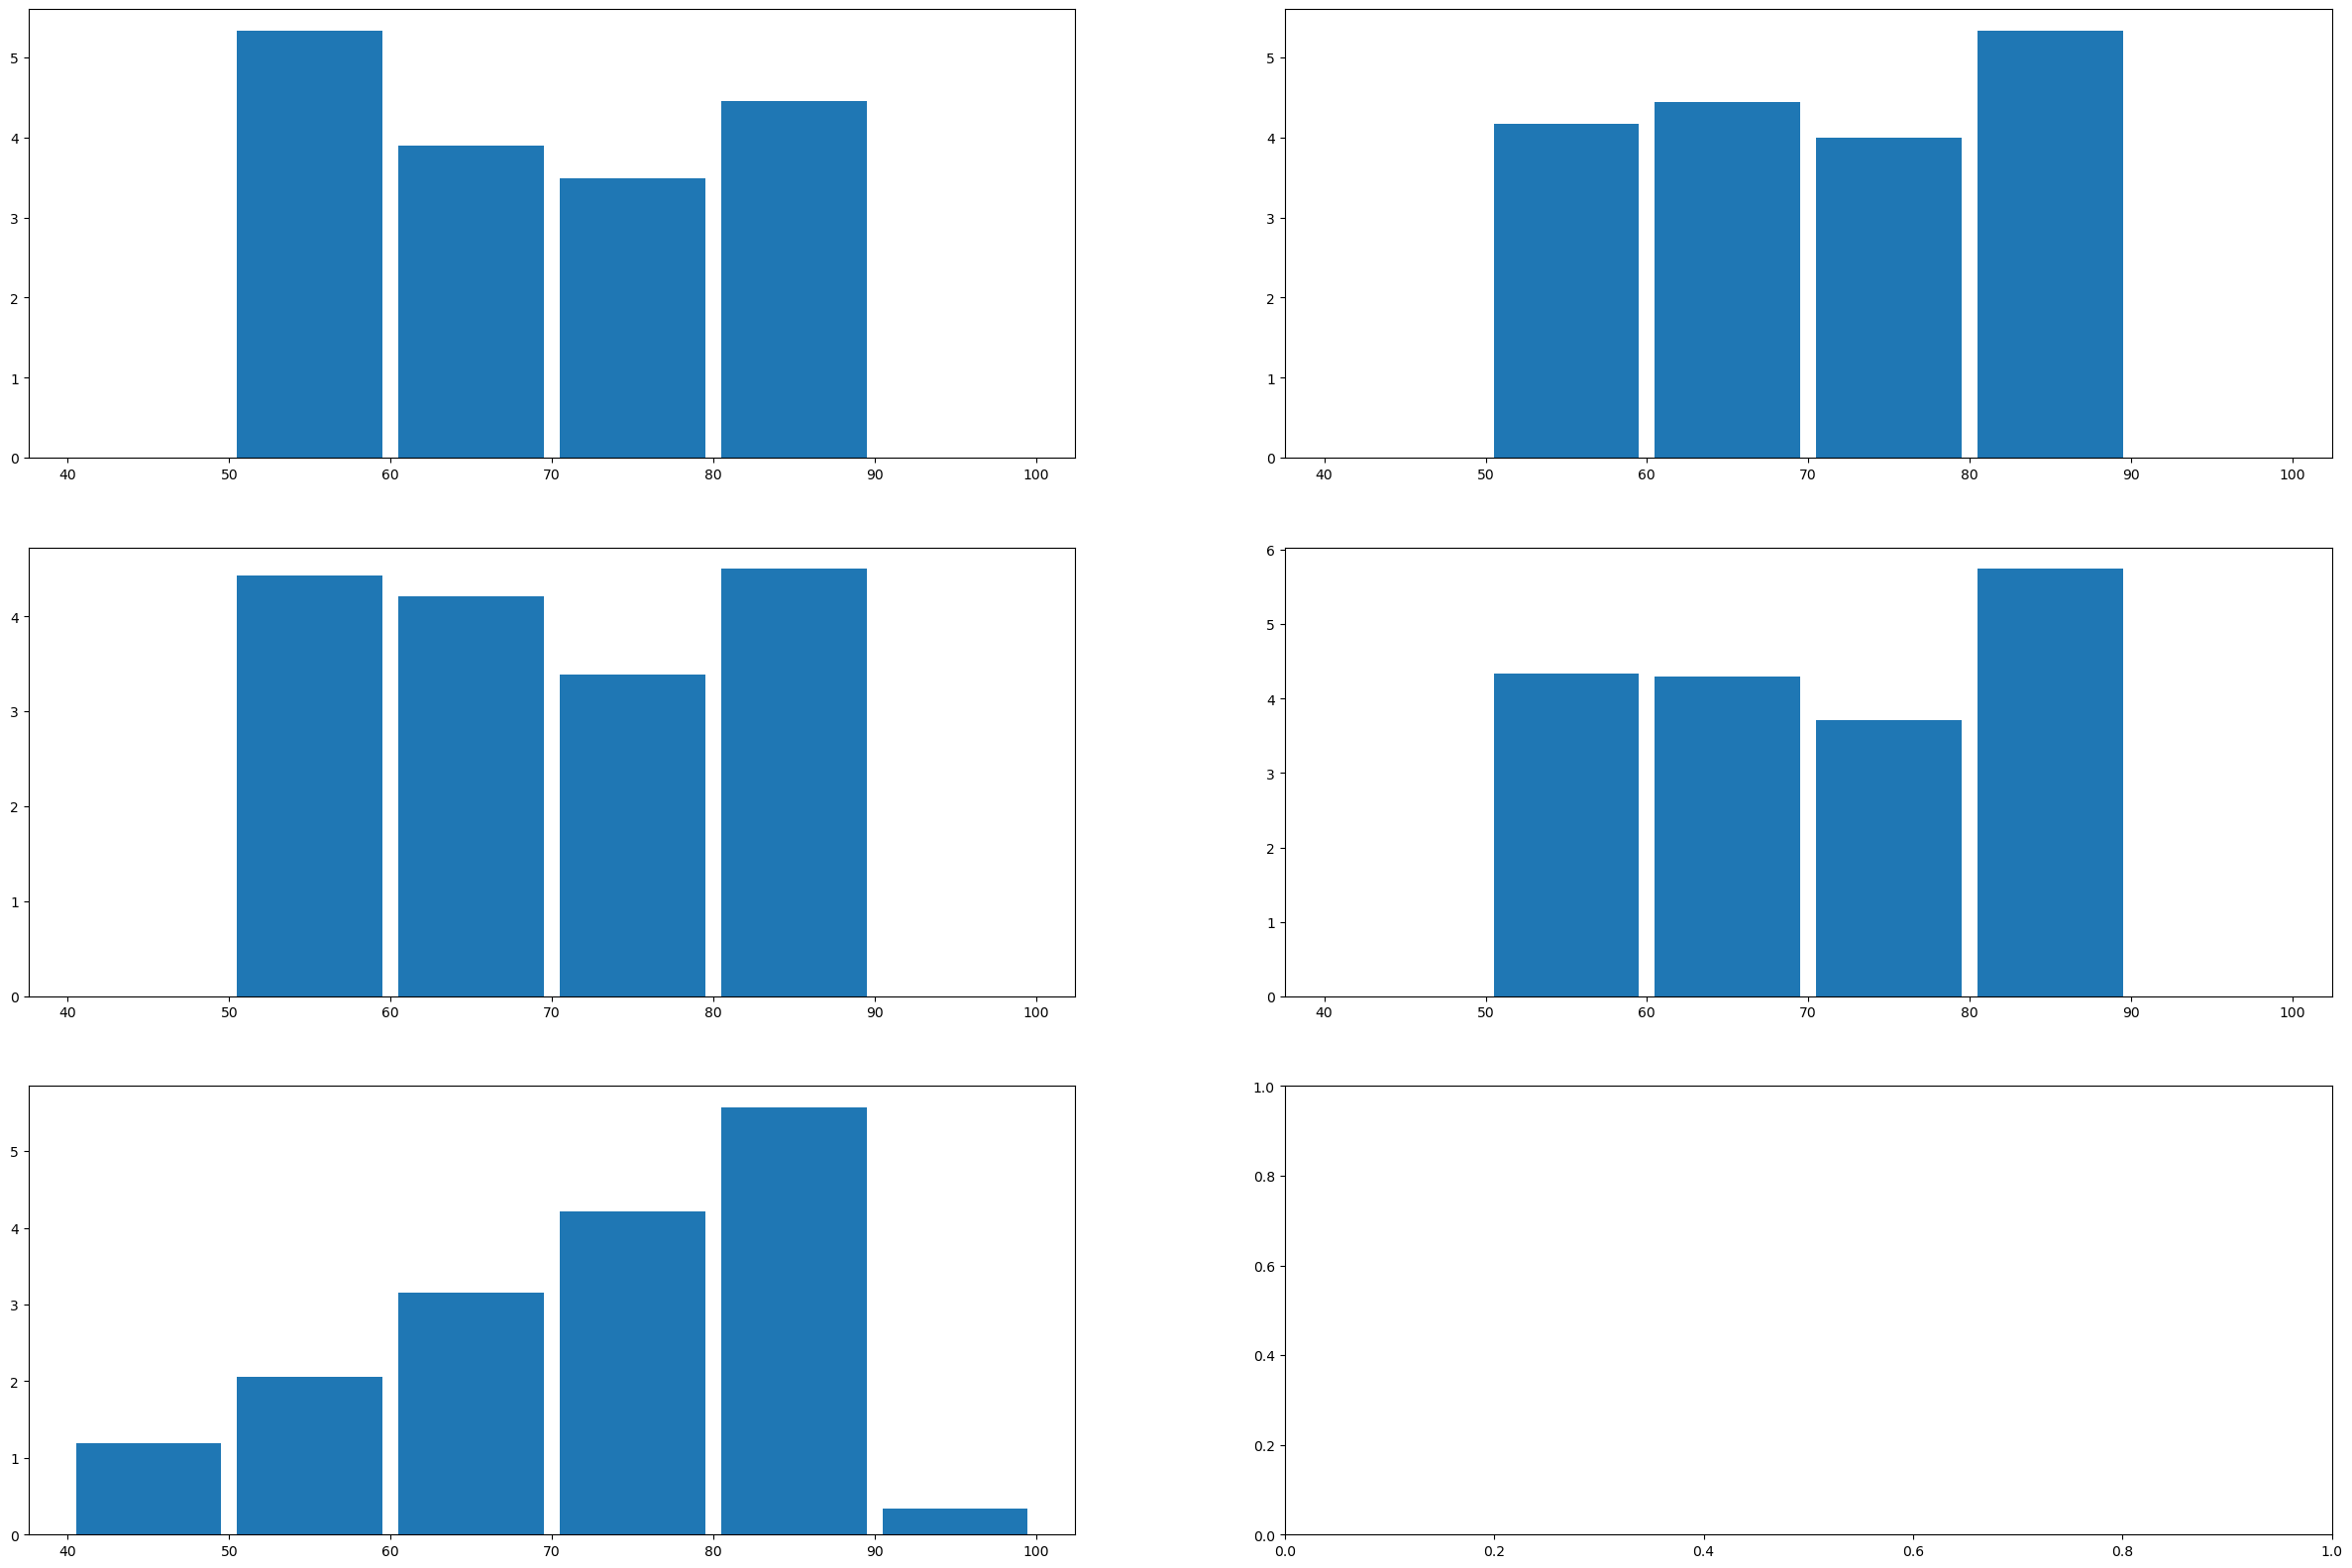

In [ ]:
# 测试泛化误差
"""
重采样后，经过检查，泛化误差主要集中在40-50和90-100两个区间
"""

# XGBoost
fold_num = 5

kf = KFold(n_splits=fold_num)
fold_scores = []
fold_y_preds = []
fold_y_valids = []
for i, (train_ids, valid_ids) in enumerate(kf.split(X_train)):
    # split validation data
    fold_X_train = X_train[train_ids]
    fold_y_train = y_train[train_ids]
    fold_X_valid = X_train[valid_ids]
    fold_y_valid = y_train[valid_ids]

    # train model
    model = xgb.XGBRegressor(n_estimators=150, max_depth=5, learning_rate=0.11, n_jobs=20)
    model.fit(fold_X_train, fold_y_train.ravel())
    fold_y_pred = np.round(model.predict(fold_X_valid))
    fold_y_preds.append(fold_y_pred.ravel())
    fold_y_valids.append(fold_y_valid.ravel())

    # calculate score
    fold_scores.append(r2_score(fold_y_valid, fold_y_pred))
fold_score = np.average(fold_scores)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30, 20))
for i, (fold_y_pred, fold_y_valid) in enumerate(zip(fold_y_preds, fold_y_valids)):
    fold_y_error = np.abs(fold_y_pred - fold_y_valid)
    sub_errors = []
    for start_age in range(40, 100, 10):
        sub_y_id = ((fold_y_valid >= start_age) & (fold_y_valid < start_age + 10))
        sub_y_error = (fold_y_error * sub_y_id).sum() / sub_y_id.sum()
        sub_errors.append(sub_y_error)

    axes[i // 2][i % 2].bar(range(45, 100, 10), sub_errors, width=9)